In [47]:
import itertools
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import f1_score
import multiprocessing as mp
import os

In [48]:
# Test different feature vectors for each sequence
d = {'A':0,'G':1,'C':2,'T':3}

# Construct k-mer dictionary
kmer_to_ind = {}
ind_to_kmer = {}
k_ind = 0
for k in range(1,6):
    for kmer in [''.join(i) for i in itertools.product('ACGT', repeat = k)]:
        kmer_to_ind[kmer] = k_ind
        ind_to_kmer[k_ind] = kmer
        k_ind += 1

# Feature mapping 1: char to int
def seq_to_int(s):
    return map(lambda x: d[x], s)

# Feature mapping 2: k-mer counting for k = 1, 2, 3, 4, 5
def kmer_count(s):
    v = np.zeros(len(kmer_to_ind))
    for k in range(1,6):
        for kmer in [s[i:i+k] for i in range(len(s)-k+1)]:
            v[kmer_to_ind[kmer]] += 1
    return v

In [49]:
def load_features(feature_extractor,filename,num_steps=200):
    # Read in sequence
    f = open(filename)
    X = []
    start_time = time.time()
    for i,line in enumerate(f):
        if i % 1000 == 0:
            print time.time()-start_time, ' s'
        s = line.split()[0]
        a = int(len(s)/2-num_steps/2)
        b = int(len(s)/2+num_steps/2)
        X.append(feature_extractor(s[a:b]))
    return np.array(X)
  
fileprefix = '../jz-rnn-tensorflow/data/deepsea_multitask/deepsea'
feature_extractor = kmer_count

X_test = load_features(feature_extractor,fileprefix + '.data.test.txt')
X_train = load_features(feature_extractor,fileprefix + '.data.train.txt')
Y_test = np.loadtxt(fileprefix + '.labels.test.txt')
Y_train = np.loadtxt(fileprefix + '.labels.train.txt')

pickle.dump((X_test,X_train,Y_test,Y_train),file('data_200.pickle','wb'))
# X_test,X_train,Y_test,Y_train = pickle.load(file('data.pickle','rb'))

3.40938568115e-05  s
2.02744293213  s
3.98844099045  s
7.05972313881  s
9.04579591751  s
10.9841039181  s
13.5748140812  s
15.6534209251  s
3.09944152832e-05  s
2.0884039402  s
4.07371807098  s
5.92270207405  s
7.73347902298  s
9.74007296562  s
11.786616087  s
13.7249729633  s
15.4917149544  s
17.4514601231  s
19.6222150326  s
21.5734610558  s
23.5917510986  s
25.5422530174  s
27.5585720539  s
29.5418181419  s
31.5757291317  s
33.6174809933  s
35.7089309692  s
37.7776880264  s
39.8139750957  s
41.8102049828  s
43.8534440994  s
46.4420390129  s
48.4776279926  s
50.412582159  s
52.3520309925  s
54.4511890411  s
56.4619181156  s
58.43207407  s
60.4703130722  s
62.5375680923  s
64.562237978  s
66.6386730671  s
68.7366299629  s
70.8200490475  s
72.7792000771  s
74.8994369507  s
76.9358739853  s
79.0296490192  s
80.9351539612  s
82.9504590034  s
84.9907820225  s
88.0465779305  s
90.0003321171  s
92.0734860897  s
94.4482440948  s
96.9506411552  s
98.9278659821  s
100.818119049  s
102.75085616

In [7]:
# logistic regression model

def logistic_reg(inputs):
    X_test,X_train,Y_test,Y_train,i = inputs
    logreg = linear_model.LogisticRegression(C=1e6)
    logreg.fit(X_train, Y_train)
    Yhat_train = logreg.predict(X_train)
    Yhat_test = logreg.predict(X_test)
    f1_train = f1_score(Y_train,Yhat_train)
    f1_test = f1_score(Y_test,Yhat_test)
    f = open('logistic_regression_results/'+str(i))
    f.write('%.3f\t%.3f\n'%(f1_train,f1_test))
    f.close()
    return f1_train,f1_test

In [ ]:
num_tasks = np.shape(Y_train)[1]

all_f1_train = []
all_f1_test = []
start_time = time.time()
for i in range(num_tasks):
    inputs = (X_test,X_train,Y_test[:,i],Y_train[:,i])
    f1_train,f1_test = logistic_reg(inputs)
    all_f1_train.append(f1_train)
    all_f1_test.append(f1_test)
    f = open('logistic_regression_results','a')
    f.write('Task ' + str(i) + ':\tf1 train = %.3f\tf1 test = %.3f\n'%(f1_train,f1_test))
    f.close()
    print 'Task ' + str(i) + ':\tf1 train = %.3f\tf1 test = %.3f'%(f1_train,f1_test) 
    print time.time()-start_time

In [ ]:
num_tasks = np.shape(Y_train)[1]
all_inputs = [(X_test,X_train,Y_test[:,i],Y_train[:,i],i) for i in range(num_tasks)]
pool=mp.Pool(processes=40)
pool.map(logistic_reg,all_inputs)

## Logistic Regression Output Analysis

In [357]:
# Read in logistic regression results as a K-by-5 matrix where K = num tasks
# 5 entries are:
#   1. task ID
#   2. number of non-zero training examples
#   3. number of non-zero testing examples
#   4. F1 score for training (-1 if no non-zero labels)
#   5. F1 score for testing (-1 if no non-zero labels)

def logistic_regression_analysis_matrix(dirname):
    X = np.zeros([919,5])
    for i in range(919):
        f = open(dirname+str(i))
        for line in f:
            z = line.split()
        X[i,0] = i
        X[i,1] = float(z[0])
        X[i,2] = float(z[1])
        if len(z) > 3:
            X[i,3] = float(z[2])
            X[i,4] = float(z[3])
        else:
            X[i,3] = -1
            X[i,4] = -1
    return X

def get_best_tasks(X):
    # Sort tasks by F1 score (descending)
    a = sorted([(val,i,X[i,1]/float(80000)) for i,val in enumerate(X[:,4])])
    a.reverse()
    # Grab tasks with best scores
    good_inds = np.array([i[1] for i in a])
    return a, good_inds

X = logistic_regression_analysis_matrix('logistic_regression_100_results/')
a, good_inds = get_best_tasks(X)

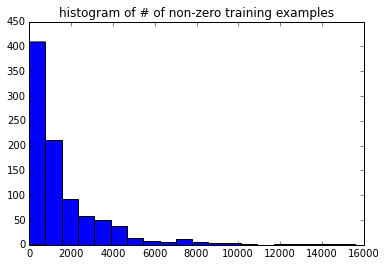

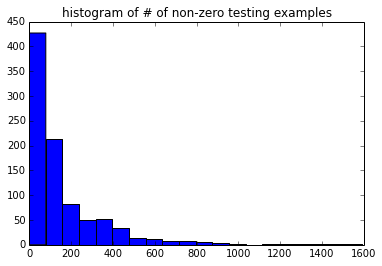

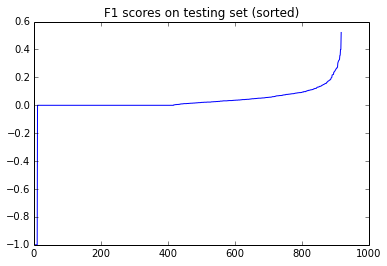

In [324]:
%matplotlib inline

# Histograms of total # of 1's in labels
plt.hist(X[:,1],bins=20)
plt.title('histogram of # of non-zero training examples')
plt.figure()
plt.hist(X[:,2],bins=20)
plt.title('histogram of # of non-zero testing examples')

# Plot of F1 scores in sorted order
plt.figure()
plt.plot(np.sort(X[:,4]))
plt.title('F1 scores on testing set (sorted)')

## Neural Network Analysis

In [168]:
# Copy over validation errors from training model on AWS
import os
key = '54.153.39.112'
os.system('scp -i ../cs224d.pem ubuntu@'+key
          +':deep_learning_genomics_nlp/jz-rnn-tensorflow/weights/*'
          +' ../jz-rnn-tensorflow/aws_weights/weights2')

0

In [381]:
# Load the F1 matrix from the validation errors file
# f = open('../jz-rnn-tensorflow/aws_weights/weights1/validation_errors')
f = open('../jz-rnn-tensorflow/aws_weights/validation_errors')

F1 = []
train_loss = []
valid_loss = []
for line in f:
    z = line.split('\t')
    F1.append([float(i) for i in z[3].translate(None,'[').translate(None,']').translate(None,'\n').split(',')])
    train_loss.append(float(z[0]))
    valid_loss.append(float(z[1]))
F1 = np.array(F1)
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)
print np.shape(F1)

(61, 919)


In [384]:
# Print out the max F1 for each of logistic regressions best-performing tasks
n = 919#179
test = []
save_tasks = []
print 'Epoch\tDeep RNN F1\tLog Reg F1\tnumber of positive training examples'
for j,(i,k) in enumerate([(np.max(F1[:,good_inds[i]]),np.argmax(F1[:,good_inds[i]])) 
                          for i in range(n)]): 
    if a[j][2]*80000 <= 800:
#         print '%d\t%3f\t%3f\t%d'%(k,i,a[j][0],a[j][2]*80000)
        test.append([i,a[j][0]])
        save_tasks.append(a[j][1])
test = np.array(test)
save_tasks = np.array(save_tasks)
print '='*80
print """The RNN beats the logistic regression model on %.1f%% of the %d tasks 
    with at least 10%% positive training examples"""%(100*np.sum(test[:,0]>test[:,1])/float(len(test)),len(test))
print 'On average, the RNN F1 score is %.3f times greater.'%(np.sum(test[:,0]-test[:,1])/len(test))

Epoch	Deep RNN F1	Log Reg F1	number of positive training examples
The RNN beats the logistic regression model on 65.6% of the 421 tasks 
    with at least 10% positive training examples
On average, the RNN F1 score is 0.086 times greater.


In [386]:
# Compare the performance of the RNN at the most recent epoch to that of the LR model 
for ii in range(len(F1)):
    test2 = []
    for j,i in enumerate([F1[ii,good_inds[i]] for i in range(n)]):
        if a[j][2]*80000 <= 800:
            test2.append([i,a[j][0]])
    test2 = np.array(test2)

    print '%d\t%.3f\t%.3f'%(ii,np.sum(test2[:,0]>test[:,1])/float(len(test2)),
                            (np.sum(test2[:,0]-test2[:,1])/len(test2)))
    
    if ii > 42: break

0	0.026	-0.008
1	0.318	0.018
2	0.342	0.024
3	0.029	-0.007
4	0.026	-0.008
5	0.055	-0.001
6	0.040	-0.005
7	0.029	-0.007
8	0.033	-0.006
9	0.048	-0.004
10	0.036	-0.006
11	0.033	-0.006
12	0.036	-0.006
13	0.040	-0.006
14	0.045	-0.005
15	0.040	-0.005
16	0.050	-0.002
17	0.033	-0.007
18	0.062	-0.002
19	0.088	0.005
20	0.038	-0.005
21	0.048	-0.004
22	0.083	0.005
23	0.048	-0.004
24	0.064	0.001
25	0.083	0.007
26	0.052	-0.003
27	0.074	0.002
28	0.100	0.008
29	0.074	0.001
30	0.052	-0.001
31	0.062	-0.000
32	0.048	-0.003
33	0.071	-0.001
34	0.093	0.002
35	0.083	0.002
36	0.069	-0.003
37	0.126	0.006
38	0.081	0.001
39	0.071	-0.002
40	0.067	-0.001
41	0.107	0.002
42	0.093	0.001
43	0.432	0.048


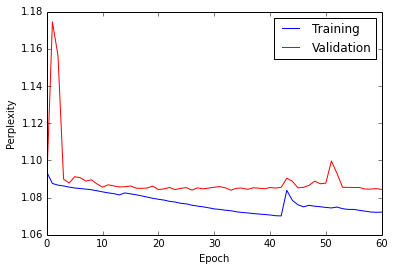

In [316]:
# Plot training and validation losses for num_steps = 100
plt.figure(figsize=(6,4))
plt.plot(train_loss,label='Training')
plt.plot(valid_loss,'r',label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.savefig('/data/deep_learning/project_deliverables/loss_100.png', format='png', dpi=900)

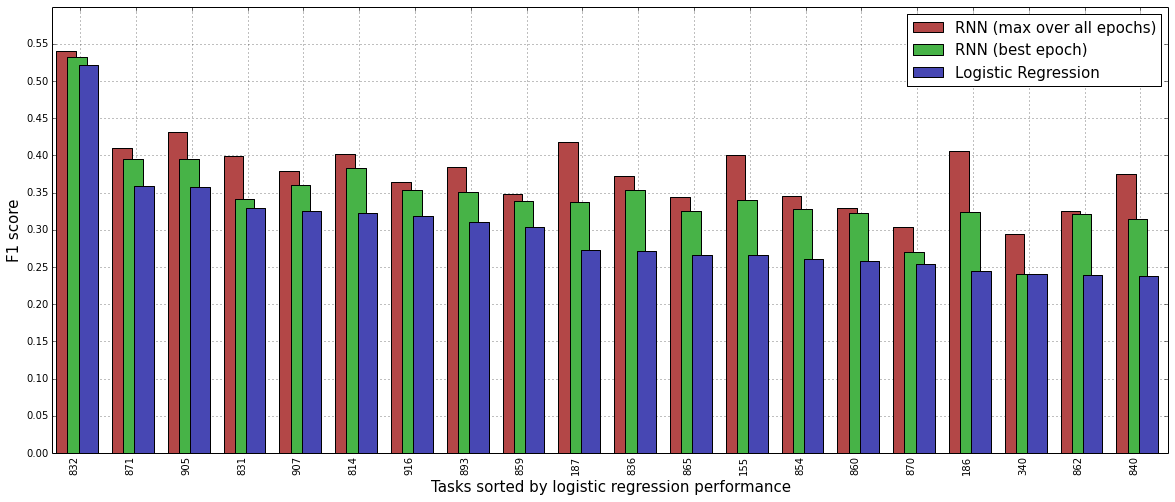

In [335]:
# Plot everything using a bar plot
import colorsys
def bars_curves_set(curves_set,labels,method_names):
    N_sets = len(curves_set)
    HSV_tuples = [(x*1.0/N_sets, 0.6, 0.7) for x in range(N_sets)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    N = len(curves_set[0])
    ind = np.arange(N)
    width = 0.35       
    fig, ax = plt.subplots(figsize=(20,8))
    plt.grid(which='minor',zorder=0)
    plt.grid(which='major',zorder=0)
    for i in range(N_sets):
        rects = ax.bar(ind-0.2+i*0.2,curves_set[i],width,color=RGB_tuples[i], 
                    ecolor='k',align='center',label=labels[i],zorder=3)
    ax.set_ylabel('F1 score',size=15)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] -0.2 for patch in rects]
    plt.xticks(xticks_pos, method_names, ha='right', rotation=90)
    plt.yticks(np.arange(0,1.1*max([max(i) for i in curves_set]),0.05))
    plt.xlim([np.min(xticks_pos)-0.5,np.max(xticks_pos)+0.5])
    plt.xlabel('Tasks sorted by logistic regression performance',size=15)
    plt.legend(fontsize=15)
    plt.savefig('/data/deep_learning/project_deliverables/F1_scores.png', format='png', dpi=200)

k = 20
curve_set = [test[:k,0],test2[:k,0],test[:k,1]]
bars_curves_set(curve_set,
            labels = ['RNN (max over all epochs)','RNN (best epoch)','Logistic Regression'],
            method_names = np.array([str(i) for i in save_tasks[:k]]))

In [340]:
np.where(test[:,1] == 0)

(array([314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
        366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
        379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
        392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
        405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
        418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430,
        431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
        444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
        470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482,
        483, 484, 485, 486, 487, 488, 489, 490, 491

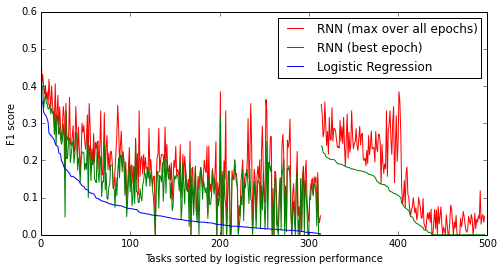

In [353]:
# Sort indices where logistic regression fails
iz = np.where(test[:,1] == 0)[0][0]
ii = np.array([j[1] for j in sorted([(a,i) for i,a in enumerate(test2[iz:,0])],reverse=True)])

iz_ind = range(iz,iz+len(ii))

plt.figure(figsize=(8,4))
plt.plot(test[:iz,0],label='RNN (max over all epochs)',c='r')
temp1 = test[iz:,0]
plt.plot(iz_ind,temp1[ii],c='r')
plt.plot(test2[:iz,0],label='RNN (best epoch)',c='g')
temp2 = test2[iz:,0]
plt.plot(iz_ind,temp2[ii],c='g')
plt.plot(test[:iz,1],label='Logistic Regression',c='b')
temp3 = test2[iz:,1]
plt.plot(iz_ind,temp3[ii],c='b')
plt.xlabel('Tasks sorted by logistic regression performance')
plt.ylabel('F1 score')
plt.legend()
plt.savefig('/data/deep_learning/project_deliverables/F1_scores_498.png', format='png', dpi=200)

## Repeating above analysis for 200 num_steps

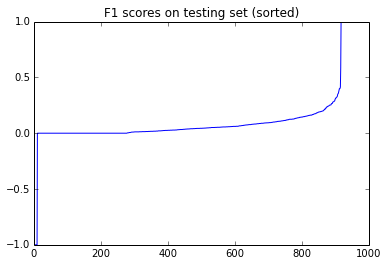

In [292]:
X = logistic_regression_analysis_matrix('logistic_regression_200_results/')
a, good_inds = get_best_tasks(X)

# Plot of F1 scores in sorted order
plt.figure()
plt.plot(np.sort(X[:,4]))
plt.title('F1 scores on testing set (sorted)')

In [293]:
# ip = '54.67.103.213'
# os.system('scp -i ../cs224d_200.pem ubuntu@'+key
#           +':deep_learning_genomics_nlp/jz-rnn-tensorflow/weights/validation_errors'
#           +' ../jz-rnn-tensorflow/aws_weights_200/')

f = open('../validation_errors')

F1 = []
train_loss = []
valid_loss = []
for line in f:
    z = line.split('\t')
    F1.append([float(i) for i in z[3].translate(None,'[').translate(None,']').translate(None,'\n').split(',')])
    train_loss.append(float(z[0]))
    valid_loss.append(float(z[1]))
F1 = np.array(F1)
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)
print np.shape(F1)

(26, 919)


In [297]:
# Print out the max F1 for each of logistic regressions best-performing tasks
n = 200
test = []
for j,(i,k) in enumerate([(np.max(F1[:,good_inds[i]]),np.argmax(F1[:,good_inds[i]])) 
                          for i in range(n)]): 
    print '%d\t%3f\t%3f'%(k,i,a[j][0]), a[j][2]*80000
    if a[j][2]*80000 > 800:
        test.append([i,a[j][0]])
test = np.array(test)
print '='*80
print """The RNN beats the logistic regression model on %.1f%% of the %d tasks 
    with at least 10%% positive training examples"""%(100*np.sum(test[:,0]>test[:,1])/float(len(test)),len(test))
print 'On average, the RNN F1 score is %.3f times greater.'%(np.sum(test[:,0]/test[:,1])/len(test))

0	0.000000	1.000000 23.0
21	0.616601	0.587000 5410.0
18	0.431138	0.414000 4354.0
18	0.426117	0.402000 7545.0
18	0.403433	0.399000 6527.0
21	0.454082	0.399000 9322.0
8	0.412698	0.380000 1373.0
21	0.447458	0.371000 7140.0
23	0.387324	0.358000 7501.0
21	0.412698	0.353000 9684.0
23	0.355828	0.349000 3851.0
0	0.000000	0.333000 22.0
9	0.356164	0.326000 1658.0
19	0.342857	0.323000 3535.0
21	0.330579	0.320000 5876.0
21	0.372093	0.315000 8599.0
2	0.095238	0.315000 517.0
0	0.000000	0.308000 62.0
21	0.334677	0.302000 13762.0
21	0.336770	0.290000 7230.0
10	0.388060	0.287000 1569.0
0	0.000000	0.286000 53.0
20	0.363636	0.282000 439.0
13	0.383838	0.281000 2219.0
3	0.334601	0.280000 5529.0
13	0.260870	0.277000 1305.0
25	0.181818	0.267000 1020.0
20	0.393305	0.266000 5933.0
16	0.216216	0.266000 1124.0
22	0.285714	0.263000 743.0
0	0.400000	0.254000 253.0
5	0.267658	0.253000 7283.0
21	0.133333	0.253000 408.0
21	0.285047	0.252000 12573.0
5	0.260870	0.252000 939.0
1	0.044444	0.250000 41.0
21	0.328638	0.2470

In [144]:
# Compare the performance of the RNN at each epoch to that of the LR model 
for j in range(len(F1)):
    print 'Line '+str(j)
    for i in range(10):
        print '%3f\t%3f'%(F1[j,good_inds[i]],a[i][0])
    print '-'*80

Line 0
0.000000	1.000000
0.411483	0.587000
0.211268	0.414000
0.289963	0.402000
0.257143	0.399000
0.221498	0.399000
0.290909	0.380000
0.252033	0.371000
0.203390	0.358000
0.258675	0.353000
--------------------------------------------------------------------------------
Line 1
0.000000	1.000000
0.442396	0.587000
0.229885	0.414000
0.262774	0.402000
0.218341	0.399000
0.278261	0.399000
0.282609	0.380000
0.262172	0.371000
0.212121	0.358000
0.259259	0.353000
--------------------------------------------------------------------------------
Line 2
0.000000	1.000000
0.472103	0.587000
0.350282	0.414000
0.330986	0.402000
0.310345	0.399000
0.329609	0.399000
0.318841	0.380000
0.312727	0.371000
0.299625	0.358000
0.331429	0.353000
--------------------------------------------------------------------------------
Line 3
0.000000	1.000000
0.458150	0.587000
0.365591	0.414000
0.348684	0.402000
0.309623	0.399000
0.318182	0.399000
0.326531	0.380000
0.329749	0.371000
0.315018	0.358000
0.300885	0.353000
---------

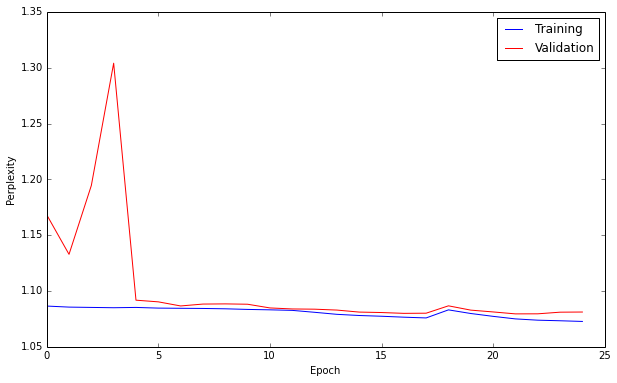

In [298]:
# Plot training and validation losses for num_steps = 100
plt.figure(figsize=(10,6))
plt.plot(train_loss[1:],label='Training')
plt.plot(valid_loss[1:],'r',label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.savefig('/data/deep_learning/project_deliverables/loss_200.eps', format='eps', dpi=900)